## 강화학습 흐름
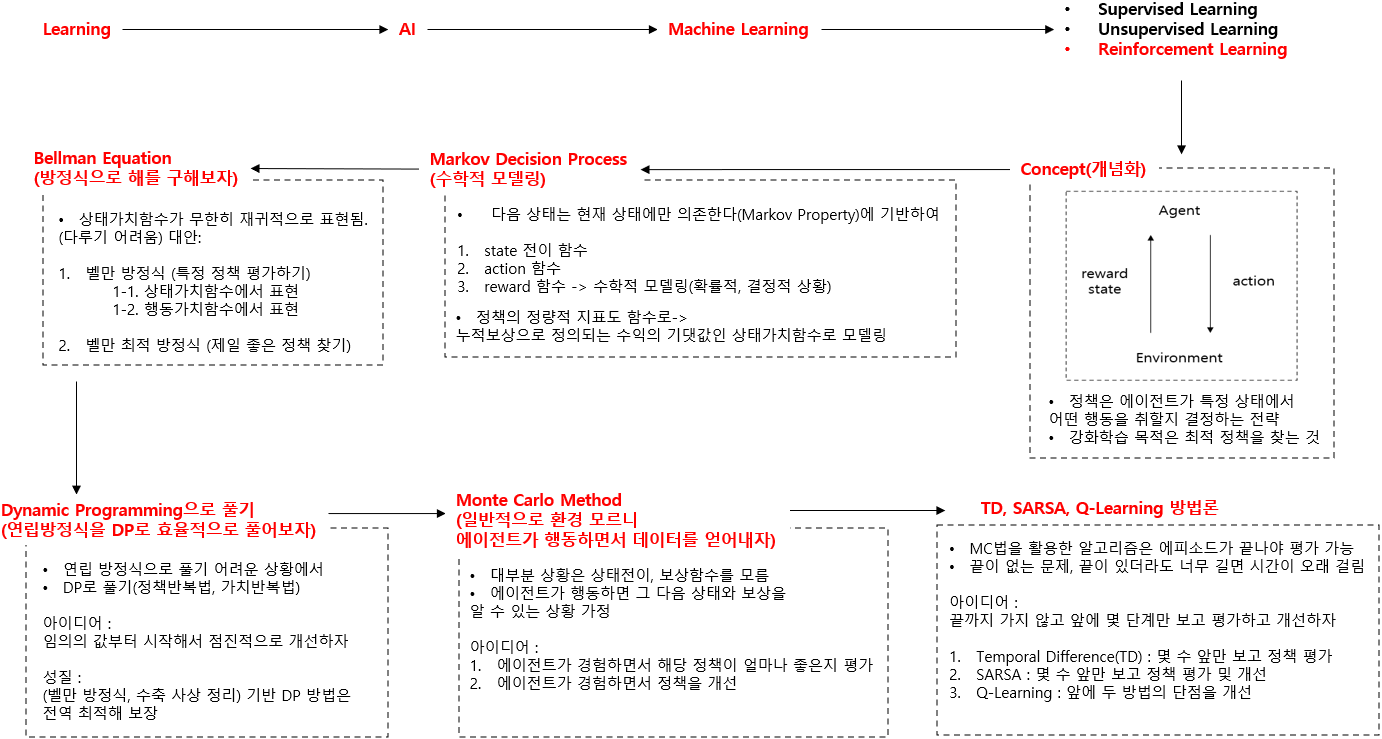
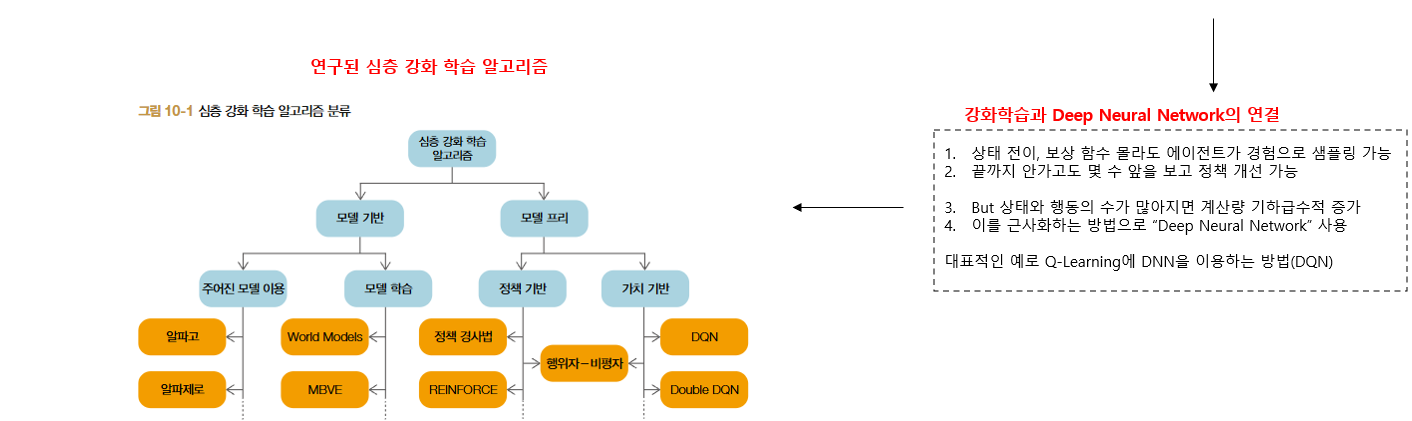

# 
#### 이번 장에서는
- 에피소드가 너무 길어지거나, 끝이 없는 과제의 경우 앞서 본 몬테카를로법을 사용할 수 없음.
- 이러한 한계점을 해결하고자 몇 수 앞만 보고 정책을 평가, 개선하는 방법을 볼 것임.
- 대표적으로 
    1. Temporal Difference(TD) 법 : 몇 수 앞만 보고 정책을 평가하는 방법
    2. SARSA : 다음 상태와 행동을 보고 현재 상태 행동을 개선하는 방법
    3. Q-Learning : TD와 SARSA의 장점을 결합한 방법

이 중에서 Q-Learning만 들여다보겠음(현재 가장 많이 사용하고 장점이 많음)

# 
# 
- 먼저 Dynamic Programming과 Monte Carlo를 비교하고, Temporal Difference 방법을 보자
    1. DP는 다음 상태의 모든 경우(기대치)를 계산한다고 할 수 있음.
    2. MC는 목적지에 도달할 때까지 한 path로 계산한다고할 수 있음.
    3. TD는 MC처럼 하나의 path로 가되, DP 처럼 다음 상태까지만 보는 것임
    4. 중점으로 배울 Q 러닝은 TD와 같은 방법임.
    #### 
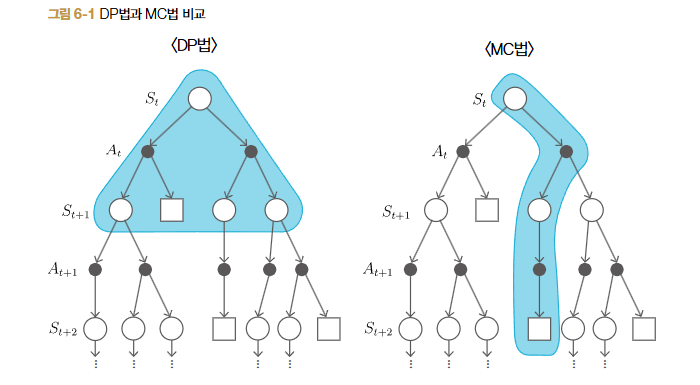
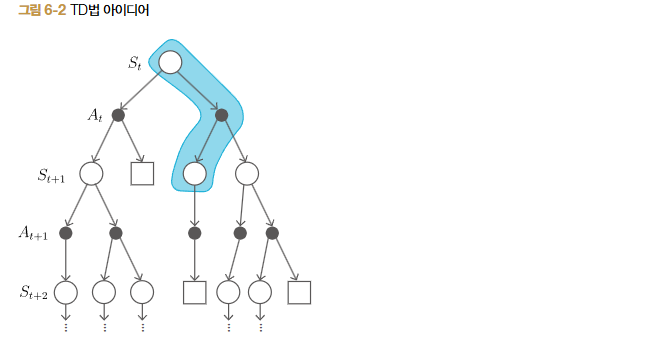

#### Q-Learning
먼저 Q 러닝의 개념을 보고 구현해보자

#### 흐름 :
- Q 러닝의 수식을 벨만 최적 방정식과 비교하여 유도해본다.

- 4장에서 배웠던 가치 반복법은 최적 정책을 얻기 위해 "평가"와 "개선" 이라는 두 과정을 하나로 묶은 기법임.
- 가치 반복법의 중요한 점은 벨만 최적 방정식에 기반하여 단 하나의 갱신식을 반복함으로써 최적 정책을 얻을 수 있다는 사실이었음.

- Q러닝을 벨만 최적 방정식으로 해석해보면
1. 벨만 최적 방정식에 의한 갱신인 동시에
2. 이를 샘플링 버전으로 만든 방법이라고 할 수 있음

Q 함수의 벨만 최적 방정식
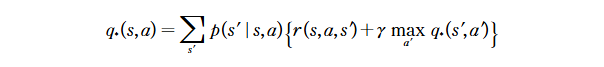
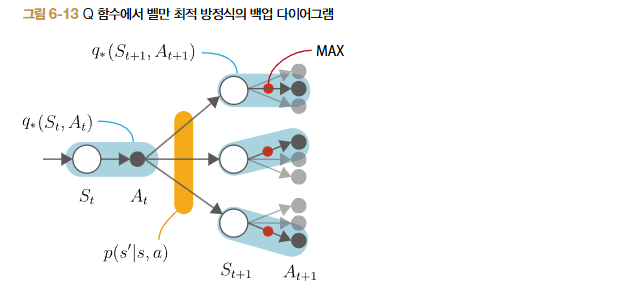
- 그림과 같이 행동 $A_{t+1}$ 은 Q 함수가 가장 큰 행동이고 이를 고름
- 위와 같이 Q 함수의 벨만 최적 방정식의 작동은 모든 가능한 다음 상태들에 대한 $S_{t+1}$ 과 모든 가능한 행동들  $A_{t+1}$ 에 대해서 가장 큰 $q$를 갖게하는 것을 찾는다는 것임.
- 그리고 재귀적이라는 것에 유의해서 들여다봐야함

위에는 가장 이상적인 최적의 경우를 들여다본 것이고, 현실 상황에서는 $q_*(s',a')$ 을 못구함. 하지만 이를 샘플링 버전으로 최대한 유사하게 구현해보면
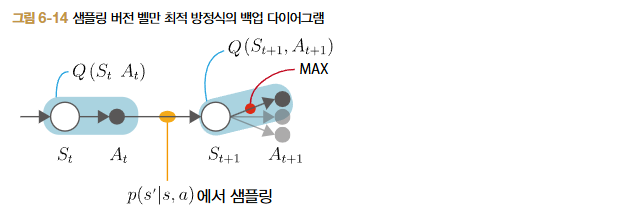

위 그림에 기반한 방법이 Q 러닝임, 즉 더욱 뒤에 모든 경우를 다 고려하지 못하므로 다음 상태의 경우에서만 계산하여 max 값을 구해보는 것임

즉 현재 상태에서 Q 값을 다음 상태에서 Q가 취할 수 있는 $Q(S_{t+1},a)$ 중에 큰 값을 선택하여 그쪽으로 개선하겠다는 것임

- Q 러닝에서 추정치 $Q(S_t, A_t)$의 목표는 $R_t + \gamma max_{a}Q(S_{t+1},a)$ 가 됨.

1. Q함수 벨만 최적 방정식
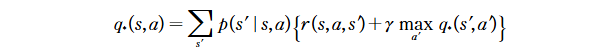
2. Q 러닝 목표함수
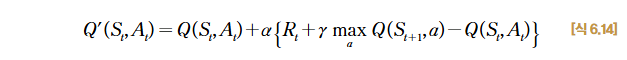

- 현재 $S_t$ 상태와 $A_t$ 행동이 추정되었을 때의 가치 함수 값인 $Q(S_t, A_t)$ 를 $Q'(S_t, A_t)$ 로 개선하겠다는 의미임.
- 개선에 사용된 식은 $\alpha \{ R_t+ \gamma max_{a}Q(S_{t+1},a) - Q(S_t, A_t) \}$ 임.
#### 그림 해석 :
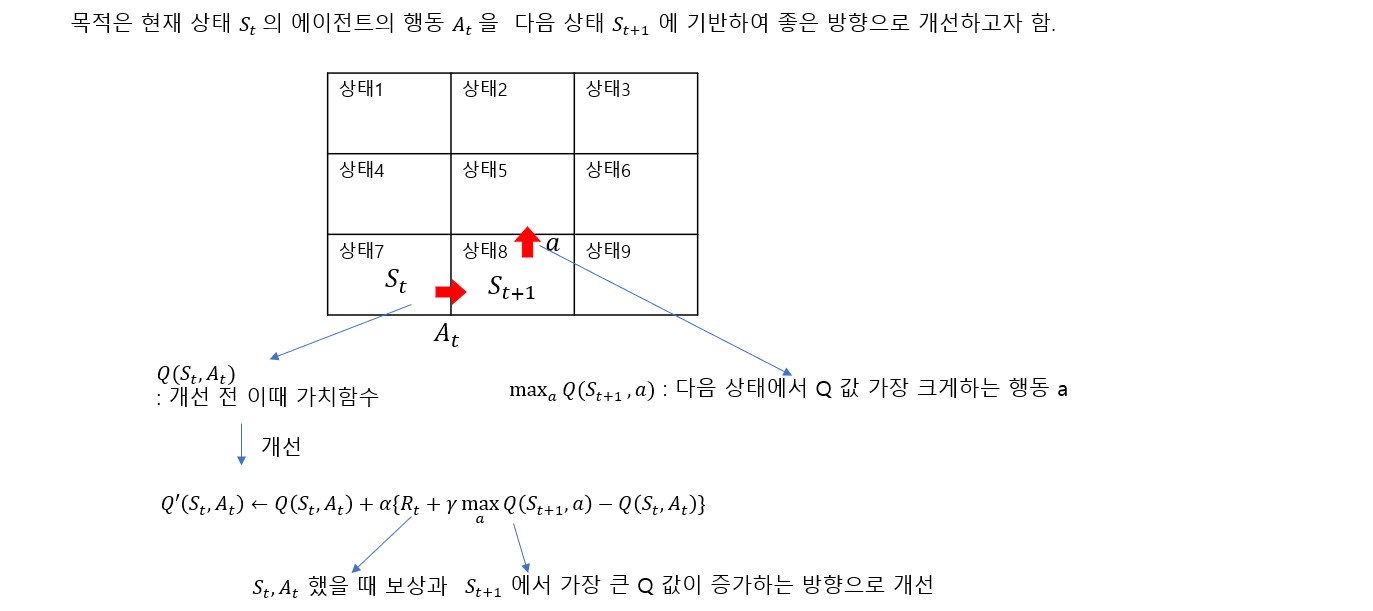
#### 직관적 해석 :
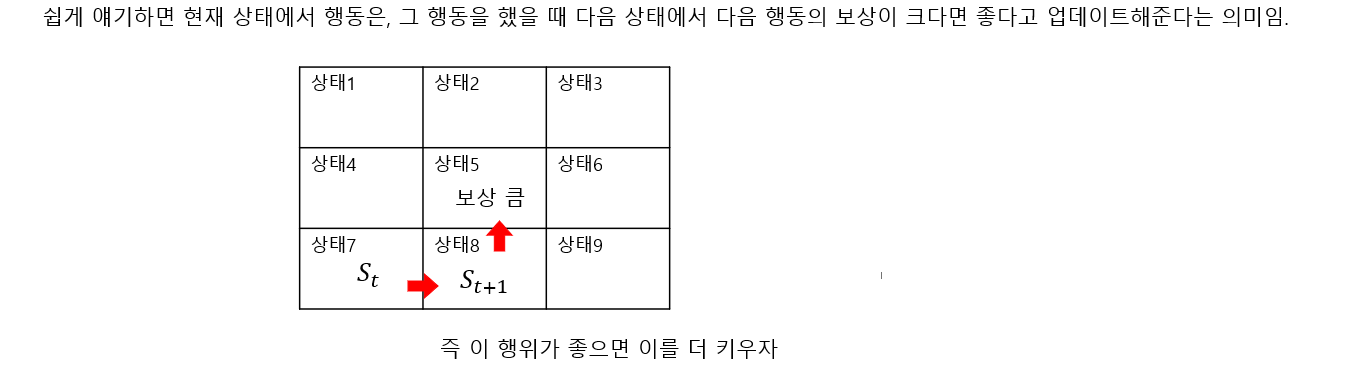

# 
### Q 러닝 구현
#### 필요한 소스 코드
1. 그리드월드
2. 그리드 확률

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict


class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]  # 행동 공간(가능한 행동들)
        self.action_meaning = {  # 행동의 의미
            0: "UP",
            1: "DOWN",
            2: "LEFT",
            3: "RIGHT",
        }

        self.reward_map = np.array(  # 보상 맵(각 좌표의 보상 값)
            [[0, 0, 0, 1.0],
             [0, None, 0, -1.0],
             [0, 0, 0, 0]]
        )
        self.goal_state = (0, 3)    # 목표 상태(좌표)
        self.wall_state = (1, 1)    # 벽 상태(좌표)
        self.start_state = (2, 0)   # 시작 상태(좌표)
        self.agent_state = self.start_state   # 에이전트 초기 상태(좌표)

    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space

    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)

    def next_state(self, state, action):
        # 이동 위치 계산
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        # 이동한 위치가 그리드 월드의 테두리 밖이나 벽인가?
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state

        return next_state  # 다음 상태 반환

    def reward(self, state, action, next_state):
        return self.reward_map[next_state]

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)
        
        
class Renderer:
    def __init__(self, reward_map, goal_state, wall_state):
        self.reward_map = reward_map
        self.goal_state = goal_state
        self.wall_state = wall_state
        self.ys = len(self.reward_map)
        self.xs = len(self.reward_map[0])

        self.ax = None
        self.fig = None
        self.first_flg = True

    def set_figure(self, figsize=None):
        fig = plt.figure(figsize=figsize)
        self.ax = fig.add_subplot(111)
        ax = self.ax
        ax.clear()
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_xticks(range(self.xs))
        ax.set_yticks(range(self.ys))
        ax.set_xlim(0, self.xs)
        ax.set_ylim(0, self.ys)
        ax.grid(True)

    def render_v(self, v=None, policy=None, print_value=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax

        if v is not None:
            color_list = ['red', 'white', 'green']
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                'colormap_name', color_list)

            # dict -> ndarray
            v_dict = v
            v = np.zeros(self.reward_map.shape)
            for state, value in v_dict.items():
                v[state] = value

            vmax, vmin = v.max(), v.min()
            vmax = max(vmax, abs(vmin))
            vmin = -1 * vmax
            vmax = 1 if vmax < 1 else vmax
            vmin = -1 if vmin > -1 else vmin

            ax.pcolormesh(np.flipud(v), cmap=cmap, vmin=vmin, vmax=vmax)

        for y in range(ys):
            for x in range(xs):
                state = (y, x)
                r = self.reward_map[y, x]
                if r != 0 and r is not None:
                    txt = 'R ' + str(r)
                    if state == self.goal_state:
                        txt = txt + ' (GOAL)'
                    ax.text(x+.1, ys-y-0.9, txt)

                if (v is not None) and state != self.wall_state:
                    if print_value:
                        offsets = [(0.4, -0.15), (-0.15, -0.3)]
                        key = 0
                        if v.shape[0] > 7: key = 1
                        offset = offsets[key]
                        ax.text(x+offset[0], ys-y+offset[1], "{:12.2f}".format(v[y, x]))

                if policy is not None and state != self.wall_state:
                    actions = policy[state]
                    max_actions = [kv[0] for kv in actions.items() if kv[1] == max(actions.values())]

                    arrows = ["↑", "↓", "←", "→"]
                    offsets = [(0, 0.1), (0, -0.1), (-0.1, 0), (0.1, 0)]
                    for action in max_actions:
                        arrow = arrows[action]
                        offset = offsets[action]
                        if state == self.goal_state:
                            continue
                        ax.text(x+0.45+offset[0], ys-y-0.5+offset[1], arrow)

                if state == self.wall_state:
                    ax.add_patch(plt.Rectangle((x,ys-y-1), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
        plt.show()

    def render_q(self, q, show_greedy_policy=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax
        action_space = [0, 1, 2, 3]

        qmax, qmin = max(q.values()), min(q.values())
        qmax = max(qmax, abs(qmin))
        qmin = -1 * qmax
        qmax = 1 if qmax < 1 else qmax
        qmin = -1 if qmin > -1 else qmin


        color_list = ['red', 'white', 'green']
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'colormap_name', color_list)

        for y in range(ys):
            for x in range(xs):
                for action in action_space:
                    state = (y, x)
                    r = self.reward_map[y, x]
                    if r != 0 and r is not None:
                        txt = 'R ' + str(r)
                        if state == self.goal_state:
                            txt = txt + ' (GOAL)'
                        ax.text(x+.05, ys-y-0.95, txt)

                    if state == self.goal_state:
                        continue

                    tx, ty = x, ys-y-1

                    action_map = {
                        0: ((0.5+tx, 0.5+ty), (tx+1, ty+1), (tx, ty+1)),
                        1: ((tx, ty), (tx+1, ty), (tx+0.5, ty+0.5)),
                        2: ((tx, ty), (tx+0.5, ty+0.5), (tx, ty+1)),
                        3: ((0.5+tx, 0.5+ty), (tx+1, ty), (tx+1, ty+1)),
                    }
                    offset_map = {
                        0: (0.1, 0.8),
                        1: (0.1, 0.1),
                        2: (-0.2, 0.4),
                        3: (0.4, 0.4),
                    }
                    if state == self.wall_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
                    elif state in self.goal_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0., 1., 0., 1.)))
                    else:

                        tq = q[(state, action)]
                        color_scale = 0.5 + (tq / qmax) / 2  # normalize: 0.0-1.0

                        poly = plt.Polygon(action_map[action],fc=cmap(color_scale))
                        ax.add_patch(poly)

                        offset= offset_map[action]
                        ax.text(tx+offset[0], ty+offset[1], "{:12.2f}".format(tq))
        plt.show()

        if show_greedy_policy:
            policy = {}
            for y in range(self.ys):
                for x in range(self.xs):
                    state = (y, x)
                    qs = [q[state, action] for action in range(4)]  # action_size
                    max_action = np.argmax(qs)
                    probs = {0:0.0, 1:0.0, 2:0.0, 3:0.0}
                    probs[max_action] = 1
                    policy[state] = probs
            self.render_v(None, policy)

In [2]:
def argmax(xs):
    idxes = [i for i, x in enumerate(xs) if x == max(xs)]
    if len(idxes) == 1:
        return idxes[0]
    elif len(idxes) == 0:
        return np.random.choice(len(xs))

    selected = np.random.choice(idxes)
    return selected


def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = argmax(qs)  # OR np.argmax(qs)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs


def plot_total_reward(reward_history):
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(range(len(reward_history)), reward_history)
    plt.show()

In [3]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        self.Q = defaultdict(lambda:0)
        
    def get_action(self, state):
        if np.random.rand() < self.epsilon :# epsilon 확률로 무작위 행동
            return np.random.choice(self.action_size)
        else : 
            qs = [self.Q[state, a] for a in range(self.action_size)]
            return np.argmax(qs)
        
    def update(self, state, action, reward, next_state, done):
        if done : 
            next_q_max = 0
        else :
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)
    
        target = self.gamma * next_q_max + reward
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

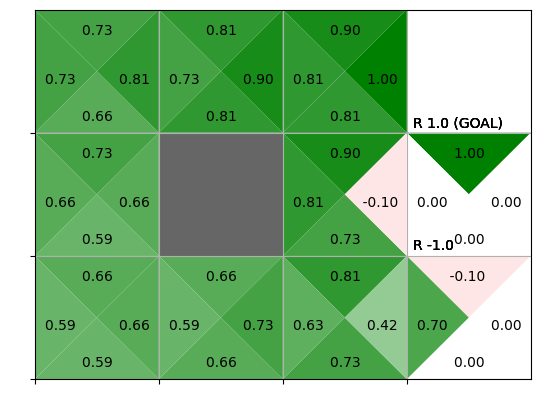

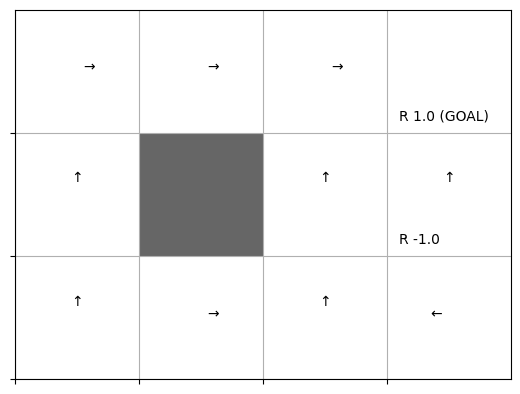

In [4]:
env = GridWorld()
agent = QLearningAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    
    while True :
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.update(state, action, reward, next_state, done)
        if done : 
            break
        state = next_state
env.render_q(agent.Q)

단계별로 들여다보기

In [15]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        self.Q = defaultdict(lambda:0)
        
    def get_action(self, state):
        if np.random.rand() < self.epsilon :# epsilon 확률로 무작위 행동
            return np.random.choice(self.action_size)
        else : 
            qs = [self.Q[state, a] for a in range(self.action_size)]
            return np.argmax(qs)
        
    def update(self, state, action, reward, next_state, done):
        if done : 
            next_q_max = 0
        else :
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            #print("next_qs : ", next_qs)
            next_q_max = max(next_qs)
            #print("next q max : ", next_q_max)
    
        target = self.gamma * next_q_max + reward
        #print("target : ", target)
        #print("업데이트 전 Q : ", self.Q)
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        #print("업데이트 후 Q : ", self.Q)

28  회 
defaultdict(<function QLearningAgent.__init__.<locals>.<lambda> at 0x000001B62FD79A20>, {((2, 0), 0): 0.0, ((2, 0), 1): 0, ((2, 0), 2): 0, ((2, 0), 3): 0, ((1, 0), 0): 0.0, ((1, 0), 1): 0, ((1, 0), 2): 0, ((1, 0), 3): 0, ((0, 0), 0): 0.0, ((0, 0), 1): 0, ((0, 0), 2): 0, ((0, 0), 3): 0.0, ((0, 1), 0): 0.0, ((0, 1), 1): 0, ((0, 1), 2): 0, ((0, 1), 3): 0.0, ((0, 2), 0): 0.0, ((0, 2), 1): 0, ((0, 2), 2): 0, ((0, 2), 3): 0.8})
176  회 
defaultdict(<function QLearningAgent.__init__.<locals>.<lambda> at 0x000001B62FD79A20>, {((2, 0), 0): 0.0, ((2, 0), 1): 0, ((2, 0), 2): 0.0, ((2, 0), 3): 0, ((1, 0), 0): 0.0, ((1, 0), 1): 0, ((1, 0), 2): 0.0, ((1, 0), 3): 0, ((0, 0), 0): 0.0, ((0, 0), 1): 0.0, ((0, 0), 2): 0.0, ((0, 0), 3): 0.0, ((0, 1), 0): 0.0, ((0, 1), 1): 0, ((0, 1), 2): 0, ((0, 1), 3): 0.5760000000000001, ((0, 2), 0): 0.0, ((0, 2), 1): 0, ((0, 2), 2): 0, ((0, 2), 3): 0.96})
184  회 
defaultdict(<function QLearningAgent.__init__.<locals>.<lambda> at 0x000001B62FD79A20>, {((2, 0), 0):

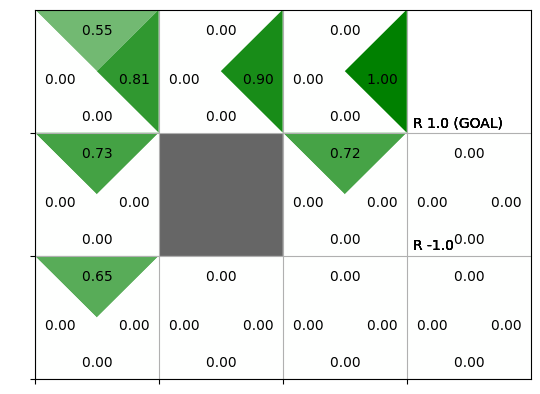

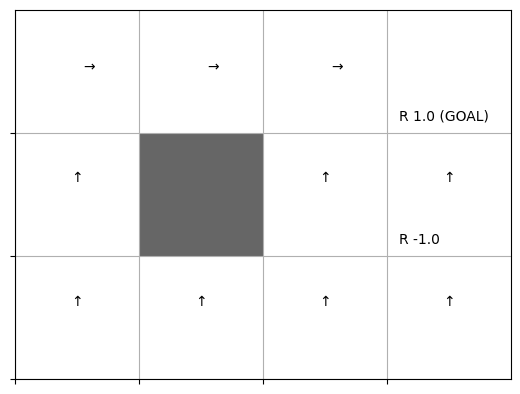

In [17]:
env = GridWorld()
agent = QLearningAgent()

count = 0
epi_count = 0
episodes = 10000
for episode in range(episodes):
    epi_count += 1
    state = env.reset()
    
    while True :
        count += 1
        #print(count, " 회 ")
        
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.update(state, action, reward, next_state, done)
        
        if done :
            print(count, " 회 ")
            print(agent.Q)
            break
        state = next_state
    if epi_count == 10:
        break
env.render_q(agent.Q)